# Training a GAN for Biomedical Image Generation
## Introduction
In this notebook, we will train a Generative Adversarial Network (GAN) to generate synthetic chest X-ray images. GANs are a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. GANs consist of two neural networks, a Generator and a Discriminator, which compete with each other to improve their performance.

## Libraries and Data Preparation
First, we need to import the necessary libraries and prepare our dataset. For this example, we will use TensorFlow and Keras.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import time

print(tf.__version__)

2.15.0


## Download and Preprocess the Data
For this example, we will use the Chest X-ray Images dataset from Kaggle. Ensure you have the Kaggle API installed and set up your Kaggle API credentials.

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:24<00:00, 178MB/s]
100% 2.29G/2.29G [00:24<00:00, 102MB/s]


In [ ]:
# Load and preprocess the data
data_dir = './data/chest_xray/train'

# Load dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels=None,
    label_mode=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True
)

# Normalize the images
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x: normalization_layer(x))

Found 5216 files belonging to 1 classes.


In [ ]:
normalized_ds

<_MapDataset element_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)>

## Visualize Training Data
Let's take a look at some samples from the training dataset to understand what our GAN will be learning to generate.

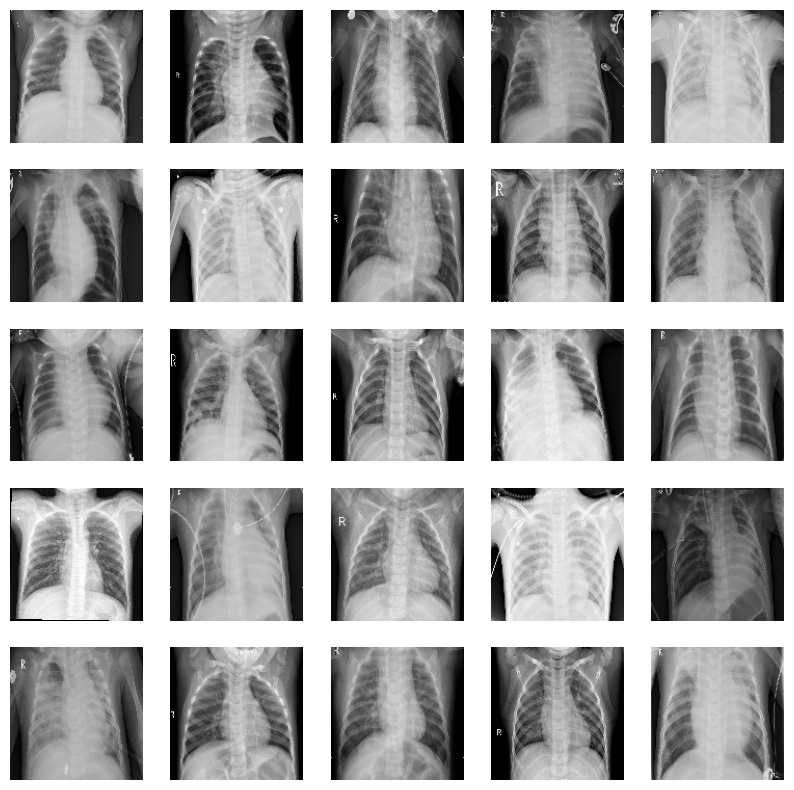

In [ ]:
def display_sample_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.axis('off')
    plt.show()

# Display 25 images from the training set
display_sample_images(normalized_ds, 25)

## Define the GAN Architecture
Next, we will define the Generator and Discriminator models.

In [ ]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(LeakyReLU())
    model.add(Reshape((16, 16, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()

def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))

    return model

discriminator = make_discriminator_model()

## Define the Loss and Optimizers
We will use Binary Crossentropy loss and Adam optimizer for both the Generator and Discriminator.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

## Training the GAN
Now, we will define the training loop for our GAN. The training loop involves:
1. Generating random noise as input for the generator.
2. Producing fake images using the generator.
3. Getting the discriminator's classification of real and fake images.
4. Calculating the loss for both the generator and the discriminator.
5. Updating the weights of the generator and discriminator using the optimizer.

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([32, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
for images in normalized_ds.take(1):
    print(images.shape)

(32, 128, 128, 1)


## Training Loop
We define the complete training loop and generate images periodically to see the progress.

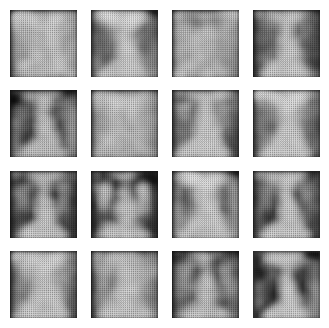

Time for epoch 1 is 765.9266884326935 sec


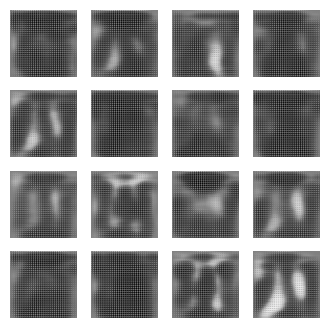

Time for epoch 2 is 765.9303870201111 sec


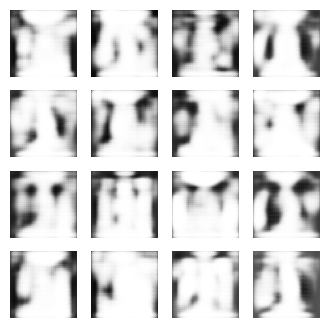

Time for epoch 3 is 767.927656173706 sec


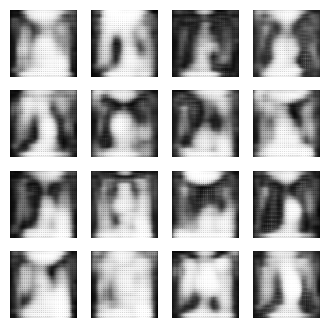

Time for epoch 4 is 761.911988735199 sec


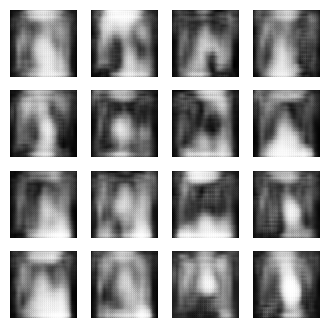

Time for epoch 5 is 753.6973316669464 sec


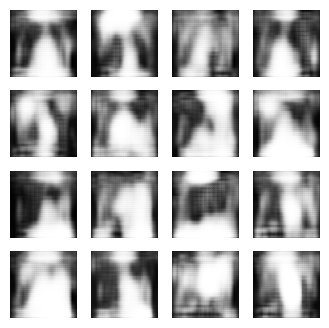

Time for epoch 6 is 754.058783531189 sec


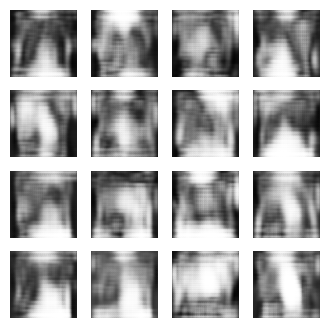

Time for epoch 7 is 751.96124792099 sec


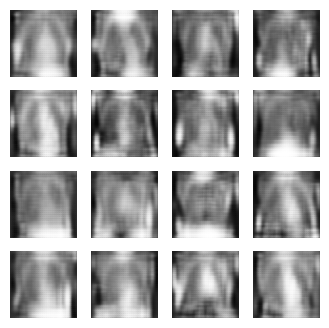

Time for epoch 8 is 755.2595524787903 sec


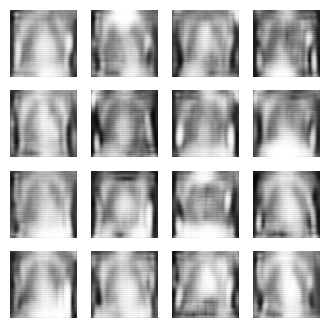

Time for epoch 9 is 790.3304891586304 sec


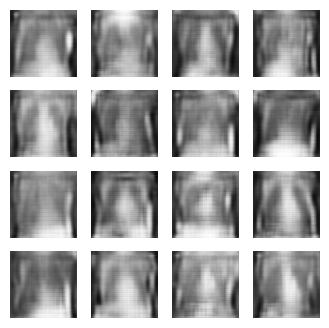

Time for epoch 10 is 764.8552775382996 sec


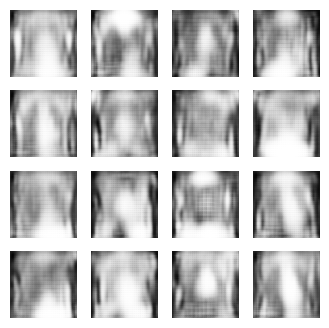

Time for epoch 11 is 755.5524823665619 sec


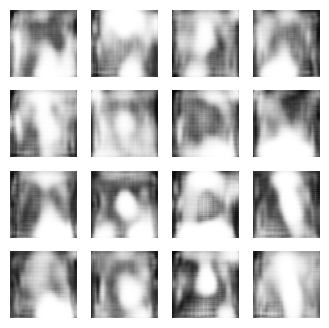

Time for epoch 12 is 759.7838370800018 sec


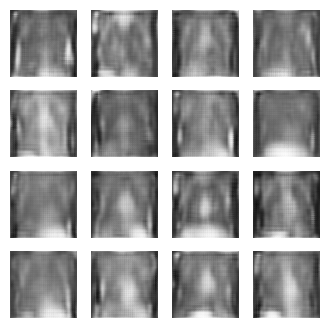

Time for epoch 13 is 758.0380403995514 sec


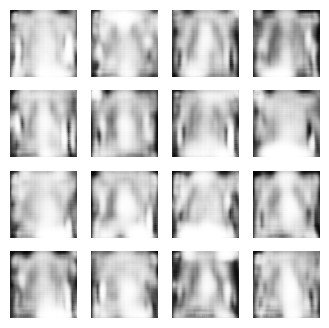

Time for epoch 14 is 751.642495393753 sec


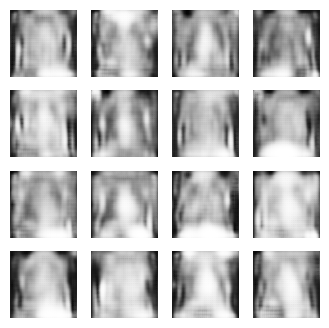

Time for epoch 15 is 753.2946798801422 sec


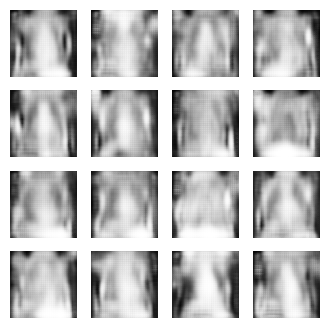

Time for epoch 16 is 752.4090404510498 sec


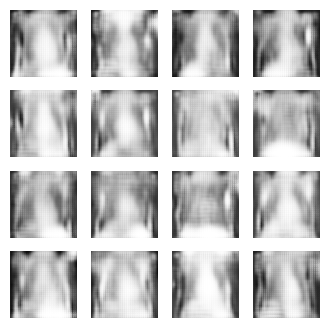

Time for epoch 17 is 751.3975512981415 sec


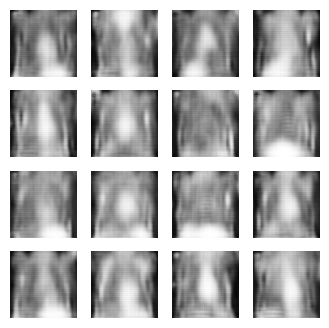

Time for epoch 18 is 752.281790971756 sec


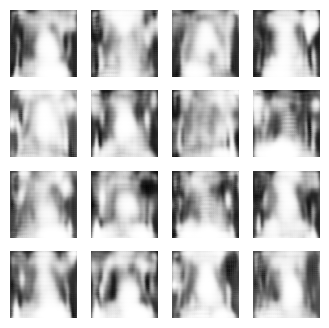

Time for epoch 19 is 751.4836325645447 sec


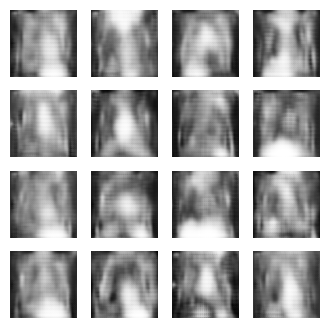

Time for epoch 20 is 752.5570113658905 sec


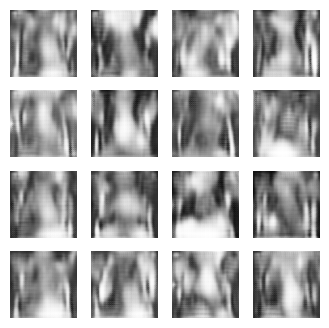

Time for epoch 21 is 754.5234360694885 sec


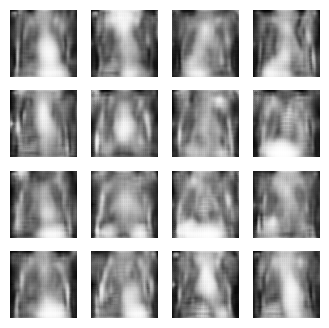

Time for epoch 22 is 750.5603325366974 sec


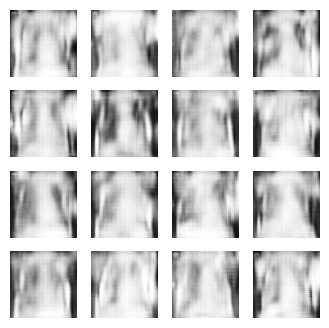

Time for epoch 23 is 751.6373674869537 sec


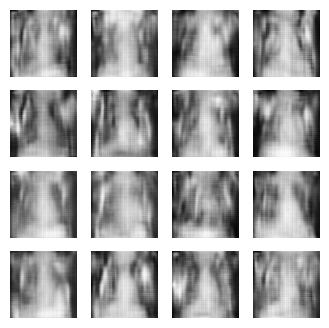

Time for epoch 24 is 753.655730009079 sec


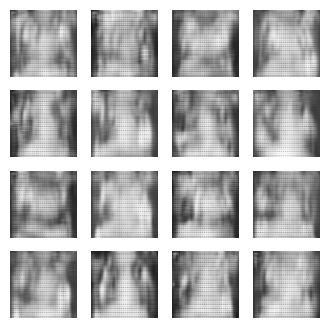

Time for epoch 25 is 754.9375772476196 sec


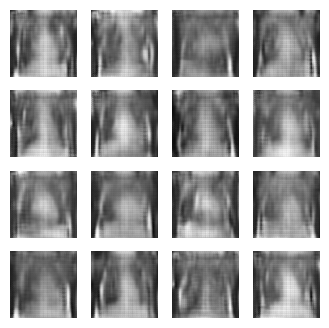

Time for epoch 26 is 752.7584462165833 sec


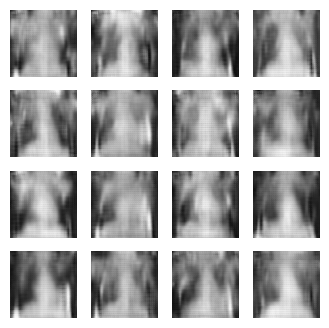

Time for epoch 27 is 754.0339915752411 sec


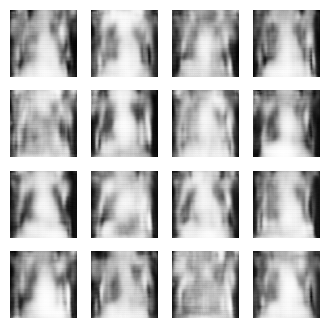

Time for epoch 28 is 755.0170760154724 sec


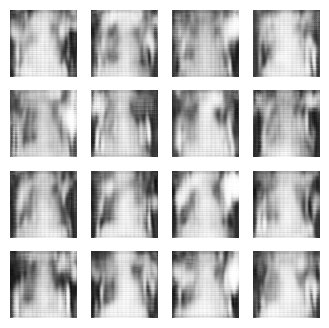

Time for epoch 29 is 749.1979274749756 sec


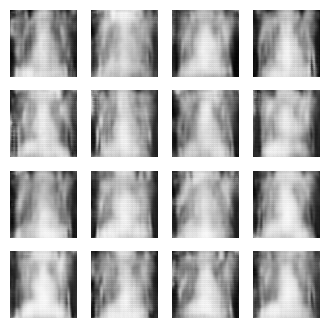

Time for epoch 30 is 752.0149667263031 sec


In [ ]:
EPOCHS = 30
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        generate_and_save_images(generator, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    generate_and_save_images(generator, epochs, seed)

train(normalized_ds, EPOCHS)

## Conclusion
In this notebook, we have successfully trained a GAN to generate synthetic chest X-ray images. GANs have the potential to significantly advance the field of biomedical imaging by providing realistic synthetic data for training other machine learning models.